In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys, json

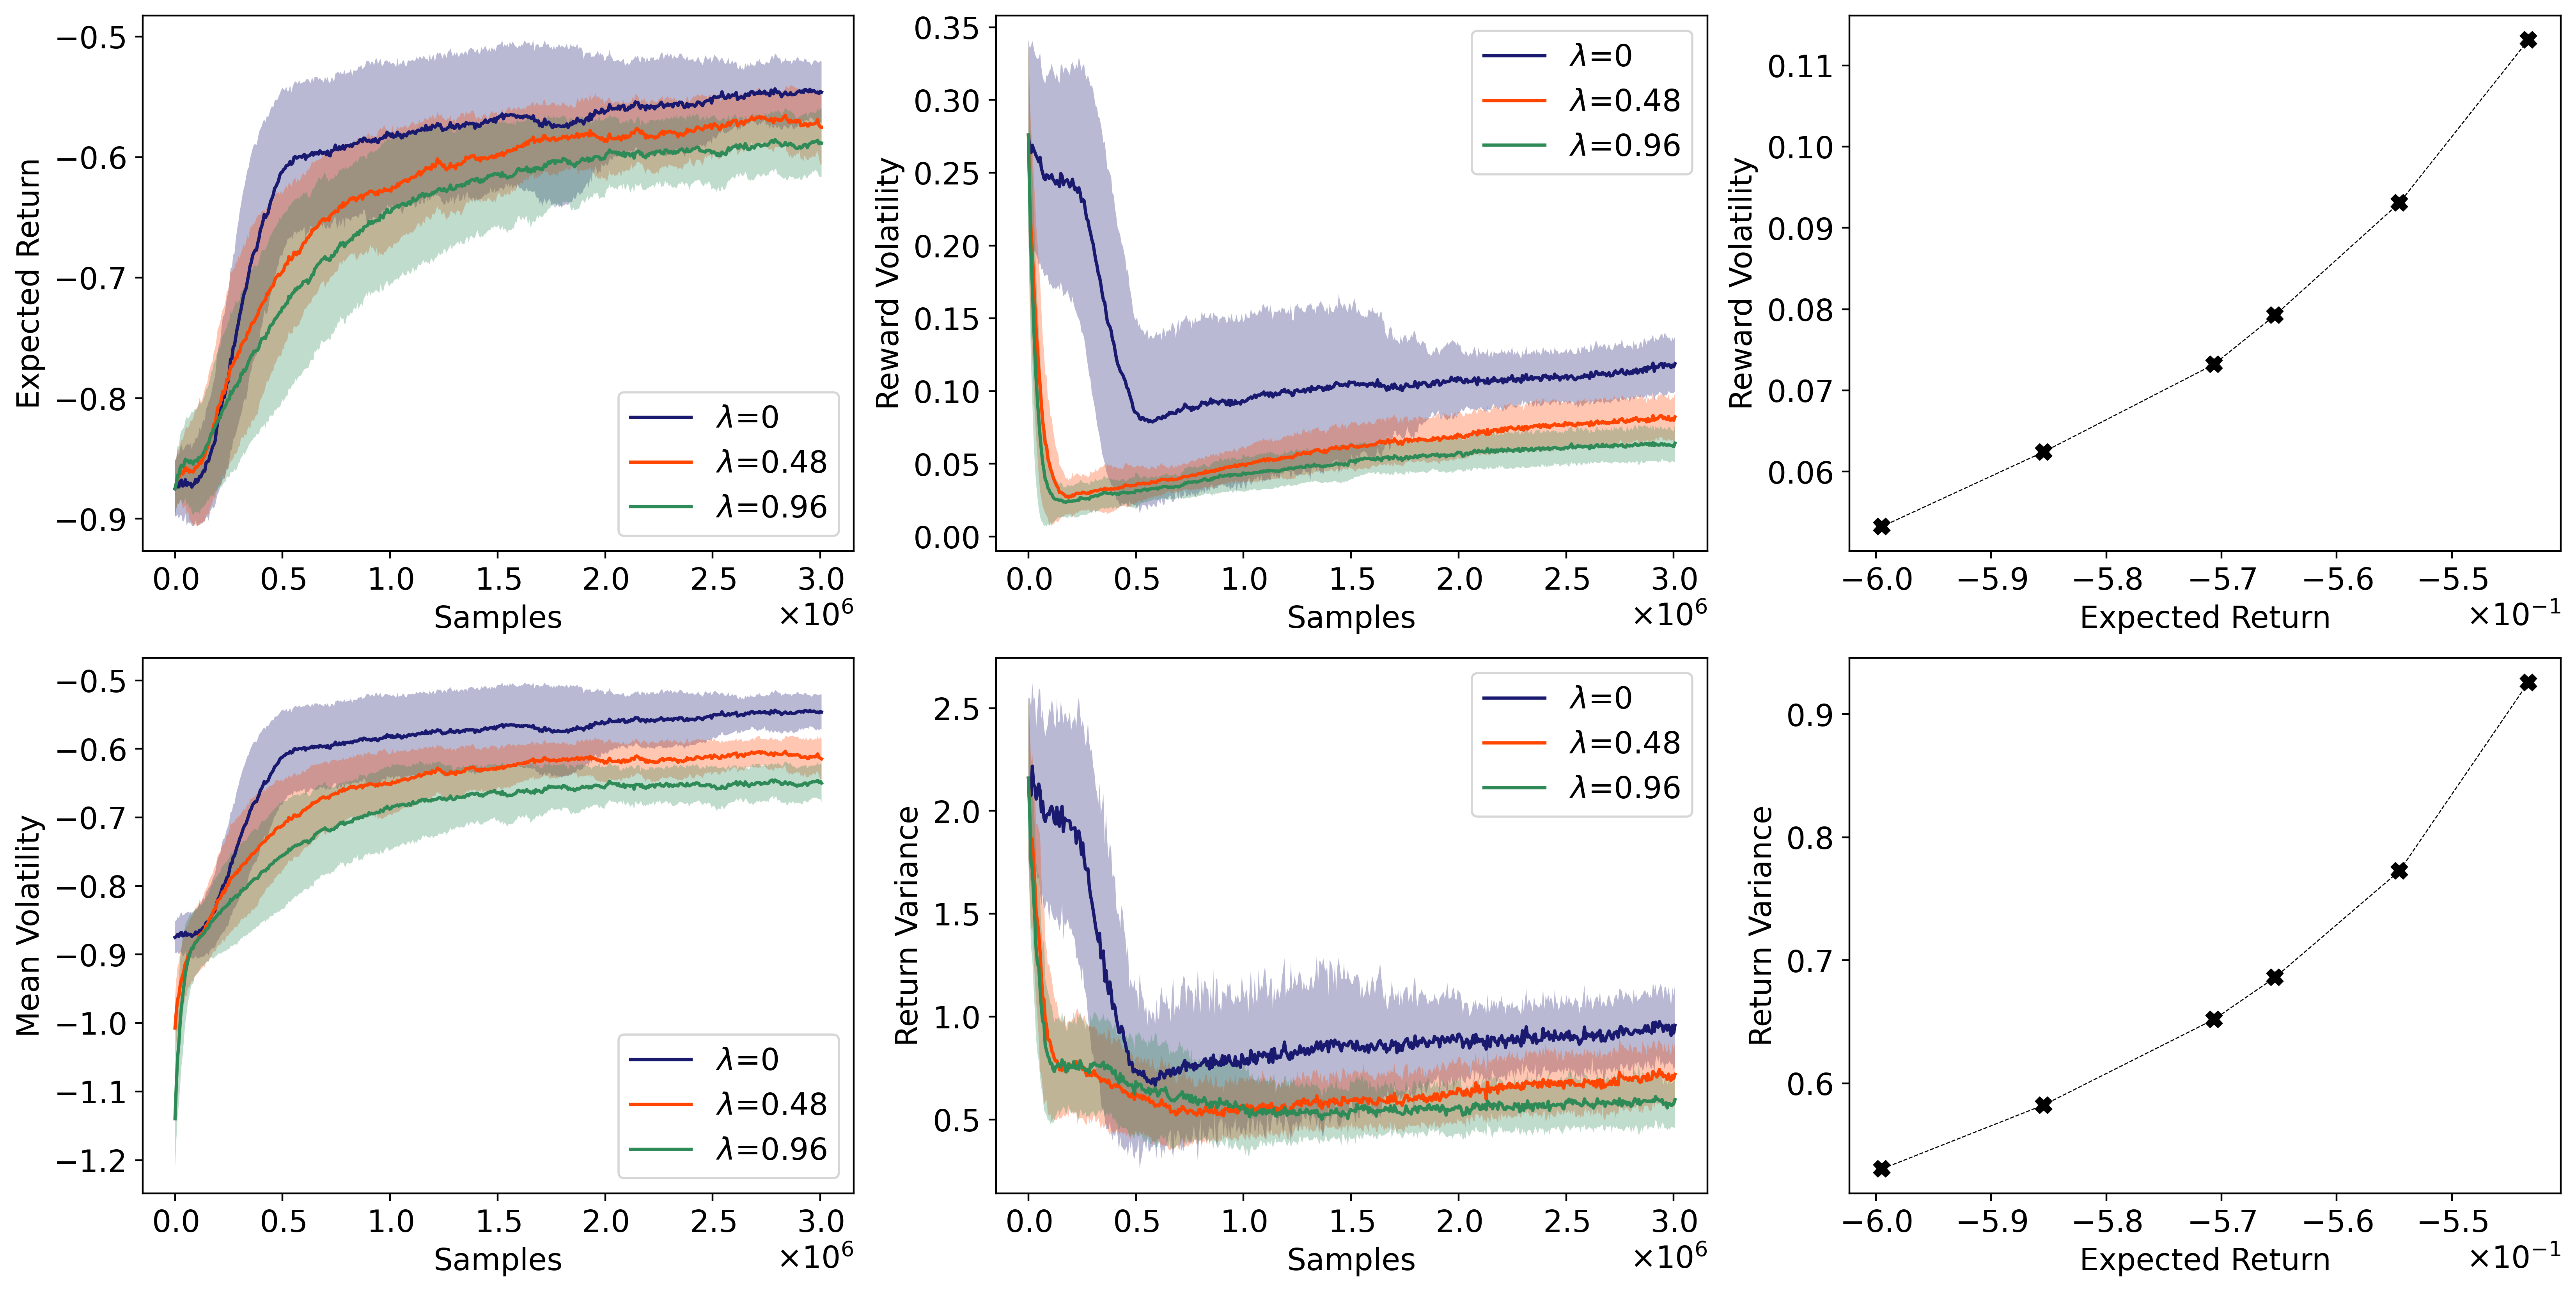

In [2]:
# Some of the used hyperparameters have to be specified here manually.
iters = 500 + 1 #number of policy update + 1  
samples_per_iter = 6000 #samples collected between policy updates, it inculdes samples collected for estimating the expected return, updating the critic, and estimating the gradient.
runs = 60 # number of independent runs (should be the same for all the values of lambda)
lmbds = np.linspace(0,1.2,6) #the values of lambda used in our experiments
lmbds_plot = [0,0.48,0.96] #the values of lambda to be included in the learning plots, the rest are only used to plot the Pareto frontiers.
seed = 100 #starting seed, specified once as it was used for all values of lambda

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(2,3, figsize=(20,10),dpi=400)
clrs = [ 'midnightblue', 'orangered','seagreen', 'gold', 'black', 'darkred']
j_x = np.linspace(0, samples_per_iter*iters, iters)

axs[0,0].set_xlabel("Samples")
axs[0,0].set_ylabel("Expected Return")
axs[0,0].ticklabel_format(style='sci', axis='x', scilimits=(-3,3), useMathText=True)

axs[0,1].set_xlabel("Samples")
axs[0,1].set_ylabel("Reward Volatility")
axs[0,1].ticklabel_format(style='sci', axis='x', scilimits=(-3,3), useMathText=True)

axs[0,2].set_xlabel("Expected Return")
axs[0,2].set_ylabel("Reward Volatility")
axs[0,2].ticklabel_format(style='sci', axis='x', scilimits=(-1,1), useMathText=True)

axs[1,0].set_xlabel("Samples")
axs[1,0].set_ylabel("Mean Volatility")
axs[1,0].ticklabel_format(style='sci', axis='x', scilimits=(-3,3), useMathText=True)

axs[1,1].set_xlabel("Samples")
axs[1,1].set_ylabel("Return Variance")
axs[1,1].ticklabel_format(style='sci', axis='x', scilimits=(-3,3), useMathText=True)

axs[1,2].set_xlabel("Expected Return")
axs[1,2].set_ylabel("Return Variance")
axs[1,2].ticklabel_format(style='sci', axis='x', scilimits=(-1,1), useMathText=True)


pareto_vol = [] #points used to plot the expected return / reward volatility frontier 
pareto_var = [] #points used to plot the expected return / return variance frontier 
start = 0 #option to start the learning plots from a certain iteration
k=0 #counter for colors

for lm in lmbds:
    if (lm==0):
        lm = 0
    exp_dir = os.path.join(os.getcwd(), 'exps/PointReacher-v4__lambda_' + str(lm).replace('.','_'))
    giant_mv = np.zeros((runs, iters))
    giant_v = np.zeros((runs, iters))
    giant_j = np.zeros((runs, iters))
    giant_var = np.zeros((runs, iters))
    for j in np.arange(runs):
        logs = np.load(os.path.join(exp_dir, str(seed+j) + ".npz"))
        giant_mv[j] = logs['mv'][:iters]   #mean-volatility logs
        giant_v[j] = logs['v'][:iters]     #reward-volatility logs 
        giant_j[j] = logs['j'] [:iters]    #expected return logs
        giant_var[j] = logs['var'][:iters] #return variance logs

        mv_avg_trace = np.mean(giant_mv, axis=0)
        mv_sd_trace = np.std(giant_mv, axis=0)

        vol_avg_trace = np.mean(giant_v, axis=0)
        vol_sd_trace = np.std(giant_v, axis=0)

        j_avg_trace = np.mean(giant_j, axis=0)
        j_sd_trace = np.std(giant_j, axis=0)

        var_avg_trace = np.mean(giant_var, axis=0)
        var_sd_trace = np.std(giant_var, axis=0)

    if (lm in lmbds_plot):
        _ = axs[0,0].fill_between(x=j_x[start:], y1=j_avg_trace[start:]-j_sd_trace[start:], y2=j_avg_trace[start:]+j_sd_trace[start:], 
                                facecolor=clrs[k],  alpha=0.3)
        _ = axs[0,0].plot(j_x[start:], j_avg_trace[start:], color=clrs[k], label="$\lambda$="+str(lm))

        _ = axs[0,1].fill_between(x=j_x[start:], y1=vol_avg_trace[start:]-vol_sd_trace[start:], y2=vol_avg_trace[start:]+vol_sd_trace[start:],
                                facecolor=clrs[k],  alpha=0.3)
        _ = axs[0,1].plot(j_x[start:], vol_avg_trace[start:], clrs[k], label="$\lambda$="+str(lm))
        
        _ = axs[1,0].fill_between(x=j_x[start:], y1=mv_avg_trace[start:]-mv_sd_trace[start:], y2=mv_avg_trace[start:]+mv_sd_trace[start:],
                                facecolor=clrs[k],  alpha=0.3)
        _ = axs[1,0].plot(j_x[start:], mv_avg_trace[start:], clrs[k], label="$\lambda$="+str(lm))
        
        _ = axs[1,1].fill_between(x=j_x[start:], y1=var_avg_trace[start:]-var_sd_trace[start:], y2=var_avg_trace[start:]+var_sd_trace[start:],
                                facecolor=clrs[k],  alpha=0.3)
        _ = axs[1,1].plot(j_x[start:], var_avg_trace[start:], clrs[k], label="$\lambda$="+str(lm))
        k+=1
    
    ind = np.argmax(mv_avg_trace) #metric used for choosing points for the frontiers
    
    pareto_vol.append((j_avg_trace[ind],vol_avg_trace[ind]))
    pareto_var.append((j_avg_trace[ind],var_avg_trace[ind]))
    
axs[0,0].legend(loc="lower right")
axs[0,1].legend(loc="upper right")
axs[1,0].legend(loc="lower right")
axs[1,1].legend(loc="upper right")

_ = axs[0,2].plot([x[0] for x in pareto_vol],[x[1] for x in pareto_vol],  'X', c='k', linestyle='--', lw=0.5, ms=7)    
_ = axs[1,2].plot([x[0] for x in pareto_var],[x[1] for x in pareto_var],  'X', c='k', linestyle='--', lw=0.5, ms=7)    
